# Mini process example - gear optimization

In [1]:
import sys
import numpy as np
import pandas as pd
sys.path.append('../..')

In [2]:
from tqdm import tqdm
from supergear import SuperGear, calculate_R

In [3]:
from lamarck.assistant import GenomeCreator
from lamarck.assistant import PopulationCreator
from lamarck import Environment

# Setup

#### Process

In [4]:
def compute_gear(z1i, z1o, di, do):
    z3i = z1i + di
    z3o = z1o + do
    gear = SuperGear(1)
    gear.set_gears(z1i, z3i, z1o, z3o)
    return {
        'R': abs(gear.R),
        'DiameterRatio': max(z3i/z3o, z3o/z3i),
        'Diameter': max(z3i, z3o),
        'MaxSatellites': min([n for n in gear.n_possible_satellites().values()])
    }

#### Optimization Function

In [5]:
def optimize_pareto(process,
                    pop,
                    outputs,
                    objectives,
                    peek_var,
                    n_generations,
                    n_dispute,
                    p_elitism=0,
                    p_mutation=0.03,
                    multi=True):
    # Population
    pop = pop.copy()
    pop.apply_fitness.add_constraint.less_or_equal('Diameter', 200)
    pop.apply_fitness.add_constraint.greater_than('R', 0)
    pop.apply_fitness.add_constraint.greater_than('MaxSatellites', 1)
    
    # Environment
    env = Environment()
    env.config.set_multi(multi)
    env.config.set_process(process)
    
    # Optimization
    pbar = tqdm(range(n_generations))
    peek = 0
    for i in pbar:
        pbar.set_description(f'[max: {peek}] Simulating...')
        env.simulate(pop)
        peek = round(pop.datasets.output[peek_var].max(), 2)
        pbar.set_description(f'[max: {peek}] Applying Fitness Criteria...')
        pop.apply_fitness.multi_objective.pareto(outputs, objectives=objectives)
        if i < n_generations:
            pbar.set_description(f'[max: {peek}] Selecting...')
            pop.select()
            pbar.set_description(f'[max: {peek}] Generating Offspring...')
            pop.reproduce.mutate(p_mutation)
            if p_elitism == 0:
                pop.reproduce.tournament(n_dispute=n_dispute)
            else:
                n_tournament_children = len(pop) * (1-p_elitism)
                n_elite_children = len(pop) * (p_elitism)
                pop.reproduce.tournament(n_dispute=n_dispute, n_children=n_tournament_children)
                pop.reproduce.elitism(n_children=n_elite_children)
    return pop

#### Genome Creation

In [6]:
genome_creator = GenomeCreator()

genome_creator.add_gene_specs.numeric(name='z1i',
                                      min=20,
                                      max=80,
                                      progression='linear',
                                      domain='int')

genome_creator.add_gene_specs.numeric(name='z1o',
                                      min=20,
                                      max=80,
                                      progression='linear',
                                      domain='int')

genome_creator.add_gene_specs.numeric(name='di',
                                      min=30,
                                      max=200,
                                      progression='linear',
                                      domain='int')

genome_creator.add_gene_specs.numeric(name='do',
                                      min=30,
                                      max=200,
                                      progression='linear',
                                      domain='int')

genome_blueprint = genome_creator.get_genome_blueprint()

# Process Benchmarks

In [7]:
outputs = ['R', 'DiameterRatio', 'Diameter']
objectives = ['max', 'min', 'min']
n_generations = 50

#### Population

In [8]:
ndet=7
nrand=2000

In [9]:
pop_creator = PopulationCreator(genome_blueprint)
pop = pop_creator.create.det(ndet) + pop_creator.create.rand(nrand)
pop.define()

#### Serial

In [10]:
serial_pop = optimize_pareto(process=compute_gear,
                             pop=pop,
                             outputs=outputs,
                             objectives=objectives,
                             peek_var='R',
                             n_generations=n_generations,
                             n_dispute=2,
                             p_elitism=0,
                             multi=False)

[max: 17135.0] Generating Offspring...: 100%|██████████| 50/50 [03:50<00:00,  4.62s/it]     


<AxesSubplot:xlabel='generation', ylabel='R'>

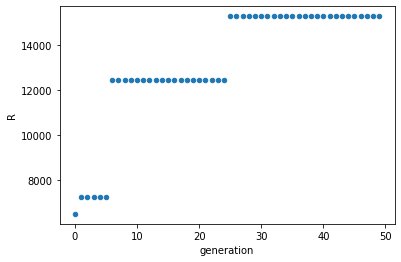

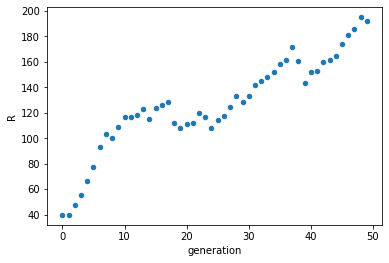

In [11]:
serial_pop.plot.history('R', max)
serial_pop.plot.history('R', 'mean')

#### Multi-Thread

In [12]:
multi_pop = optimize_pareto(process=compute_gear,
                            pop=pop,
                            outputs=outputs,
                            objectives=objectives,
                            peek_var='R',
                            n_generations=n_generations,
                            n_dispute=2,
                            p_elitism=0,
                            multi=True)

[max: 27784.0] Generating Offspring...: 100%|██████████| 50/50 [04:03<00:00,  4.86s/it]     


<AxesSubplot:xlabel='generation', ylabel='R'>

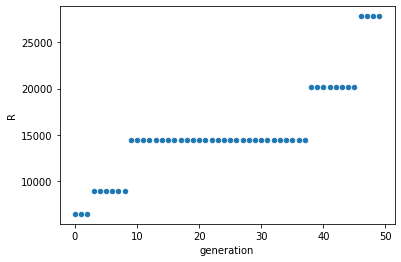

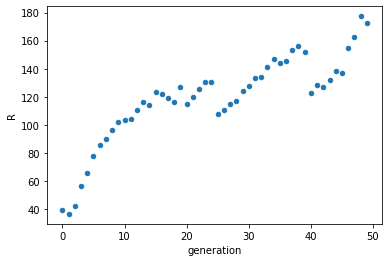

In [13]:
multi_pop.plot.history('R', max)
multi_pop.plot.history('R', 'mean')

#### n_dispute = 4

In [14]:
dispute_pop = optimize_pareto(process=compute_gear,
                              pop=pop,
                              outputs=outputs,
                              objectives=objectives,
                              peek_var='R',
                              n_generations=n_generations,
                              n_dispute=4,
                              p_elitism=0,
                              multi=True)

[max: 16899.0] Generating Offspring...: 100%|██████████| 50/50 [03:55<00:00,  4.71s/it]     


<AxesSubplot:xlabel='generation', ylabel='R'>

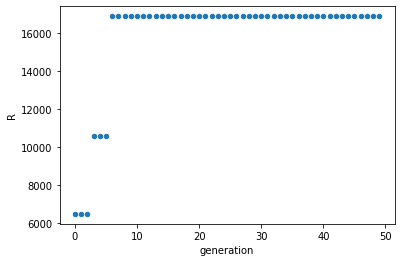

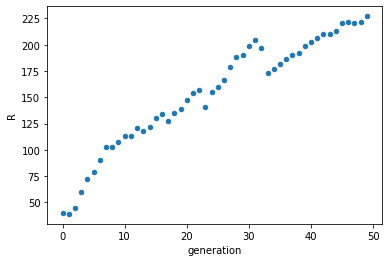

In [15]:
dispute_pop.plot.history('R', max)
dispute_pop.plot.history('R', 'mean')

#### Half Elitism

In [16]:
elitism_pop = optimize_pareto(process=compute_gear,
                              pop=pop,
                              outputs=outputs,
                              objectives=objectives,
                              peek_var='R',
                              n_generations=n_generations,
                              n_dispute=3,
                              p_elitism=0.5,
                              multi=True)

[max: 13720.0] Generating Offspring...:   0%|          | 0/50 [00:02<?, ?it/s]     Exception ignored in: <generator object generate_elite_parent_pair at 0x7f0a449bc580>
Traceback (most recent call last):
  File "<ipython-input-5-6bacb2b482a2>", line 42, in optimize_pareto
RuntimeError: generator ignored GeneratorExit
[max: 6500.0] Generating Offspring...:   2%|▏         | 1/50 [00:07<03:10,  3.89s/it]     Exception ignored in: <generator object generate_elite_parent_pair at 0x7f0a449bc580>
Traceback (most recent call last):
  File "<ipython-input-5-6bacb2b482a2>", line 42, in optimize_pareto
RuntimeError: generator ignored GeneratorExit
[max: 8378.0] Generating Offspring...:   4%|▍         | 2/50 [00:17<04:44,  5.92s/it]     Exception ignored in: <generator object generate_elite_parent_pair at 0x7f0a449bc580>
Traceback (most recent call last):
  File "<ipython-input-5-6bacb2b482a2>", line 42, in optimize_pareto
RuntimeError: generator ignored GeneratorExit
[max: 8509.5] Generating Offs

<AxesSubplot:xlabel='generation', ylabel='R'>

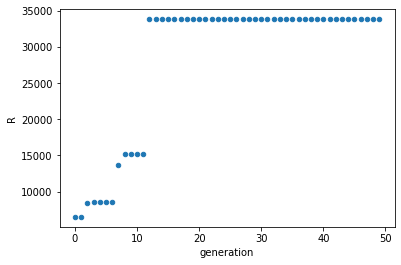

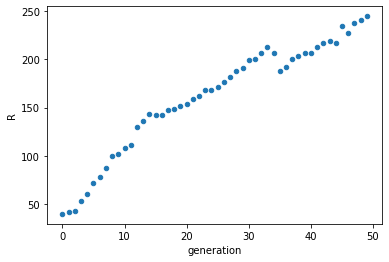

In [17]:
elitism_pop.plot.history('R', max)
elitism_pop.plot.history('R', 'mean')

In [18]:
serial_pop.datasets.fitness.sort_values('R', ascending=False).head()

,z1i,z1o,di,do,R,DiameterRatio,Diameter,MaxSatellites,criteria0,criteria1,criteria2,front,crowd
id,,,,,,,,,,,,,
-8233819876421529512,43,41,64,61,15301.0,1.049020,107.0,3.0,17.677063,-0.369506,-0.044657,1.0,inf
-345068433314756340,43,35,118,96,13363.0,1.229008,161.0,2.0,15.409626,0.387252,1.764313,2.0,inf
-7181777910245606876,73,68,58,54,12445.0,1.073770,131.0,6.0,14.335577,-0.265441,0.759329,2.0,1.613883
-9184225104025969354,34,37,57,62,12376.0,1.087912,99.0,3.0,14.254848,-0.205983,-0.312653,1.0,4.550733
1732537603474609563,27,34,58,73,11985.0,1.258824,107.0,2.0,13.797382,0.512613,-0.044657,2.0,inf


In [19]:
multi_pop.datasets.fitness.sort_values('R', ascending=False).head()

,z1i,z1o,di,do,R,DiameterRatio,Diameter,MaxSatellites,criteria0,criteria1,criteria2,front,crowd
id,,,,,,,,,,,,,
-5170335820121818887,38,37,113,110,27784.0,1.027211,151.0,5.0,28.159019,-0.446173,1.249436,1.0,inf
-1667013946885478494,59,63,74,79,27265.0,1.067669,142.0,3.0,27.629728,-0.298025,0.969098,1.0,7.867716
8308925196313721116,58,57,59,58,20124.0,1.017391,117.0,4.0,20.347146,-0.482130,0.190383,1.0,17.977593
-3825255216565491070,50,57,86,98,14416.0,1.139706,155.0,4.0,14.525975,-0.034245,1.374031,2.0,inf
-5163277540369621420,57,53,86,80,13299.0,1.075188,143.0,5.0,13.386828,-0.270493,1.000247,2.0,2.917232


In [20]:
dispute_pop.datasets.fitness.sort_values('R', ascending=False).head(5)

,z1i,z1o,di,do,R,DiameterRatio,Diameter,MaxSatellites,criteria0,criteria1,criteria2,front,crowd
id,,,,,,,,,,,,,
2532634140768856077,38,29,93,71,16899.0,1.310000,131.0,2.0,19.730517,0.600324,0.878106,1.0,inf
-730875185523665130,75,73,74,72,16241.0,1.027586,149.0,2.0,18.951799,-0.437994,1.429858,1.0,1.768562
-657312189579435405,72,73,70,71,15407.0,1.014085,144.0,2.0,17.964792,-0.487634,1.276594,1.0,6.073409
-7838292855351617729,43,42,88,86,11135.0,1.023438,131.0,5.0,12.909043,-0.453247,0.878106,1.0,5.189185
-8945649794153502964,43,44,84,86,11049.0,1.023622,130.0,5.0,12.807265,-0.452568,0.847453,1.0,0.635248


In [21]:
elitism_pop.datasets.fitness.sort_values('R', ascending=False).head(5)

,z1i,z1o,di,do,R,DiameterRatio,Diameter,MaxSatellites,criteria0,criteria1,criteria2,front,crowd
id,,,,,,,,,,,,,
-6565177609326394101,54,59,97,106,33824.0,1.092715,165.0,3.0,28.990312,-0.292238,1.015385,1.0,inf
8308925196313721116,58,57,59,58,20124.0,1.017391,117.0,4.0,17.162641,-0.480172,-0.364566,1.0,20.319682
-3951760874385782160,79,68,86,74,17325.0,1.161972,165.0,4.0,14.746170,-0.119442,1.015385,2.0,inf
-5622819676743060149,33,34,134,138,17201.0,1.029940,172.0,2.0,14.639117,-0.448863,1.216628,2.0,1.740141
2446135277801645143,49,59,88,106,15344.0,1.204380,165.0,5.0,13.035906,-0.013634,1.015385,2.0,2.021730


In [22]:
gear = SuperGear(1.2)
gear.set_gears(75, 131, 67, 117)
gear.show_specs()
gear.possible_satellites()

m:	 1
z1i:	 75
z2i:	 28
z3i:	 131
z1o:	 67
z2o:	 25
z3o:	 117
d1i:	 90
d2i:	 34
d3i:	 157
d1o:	 80
d2o:	 30
d3o:	 140
w1:	 10000
w2i:	 26786
w2o:	 26797
w3:	 5725
wi:	 10000
R:	 12052

wo:	 0.829737802854239


{'gi': [1, 2], 'go': [1, 2, 4, 8, 46, 23]}

In [23]:
(75 + 28)*1.2/2

61.8

In [24]:
(67 + 25)*1.2/2

55.199999999999996